### Installing Requirements

In [1]:
import os
import scipy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from scipy.stats import f as fdist
from scipy.stats import t as tdist
from scipy.stats import norm
from scipy.stats import ttest_ind as ttest
            
from twosample import bin_allocation_test
from multitest import MultiTest
from typing import List
from sklearn.metrics import pairwise_distances, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from hyperopt import hp

from lib.similarity import CentroidSimilarity, CentroidSimilarityFeatureSelection
from utils.hyper_parameters_tuning import model_hypopt
from utils import synthetic_data_gen
%load_ext autoreload
%autoreload 2

### Experiment 1: Scan the feature dimension

points to discuss with Alon
1. Why is the signal power dependent on number of classes?
2. How is this method better than standard feature selection methods applied on the high dimensional samples?
3. Can it be applied as a feature selection method before classification with a non-linear classifier? is such classifier not applicable here because of the small number of observations?

TODO:
1. compare to other FS methods, especially to BH FDR, but also to filter/wrapper methods (SFFS)
2. Find datasets and apply the method 
3. what happens when the data is not normal - apply permutation test

classification of normally distributed clusters
----------------------------------------------------------------
classifying data with 100 features, 3 classes, 63 train samples
normal distribution mean = 0.3716922188849839, std = 1
100%|██████████| 150/150 [00:01<00:00, 118.14trial/s, best loss: -0.3538461538461538]
SVM best parameters are {'C': 0.8120619309165029, 'degree': 7, 'kernel': 'sigmoid'}
SVM accuracy = 0.3421516754850088
-------------------------------------------------------------


classifying data with 500 features, 3 classes, 115 train samples
normal distribution mean = 0.43178494989133853, std = 1
100%|██████████| 150/150 [00:02<00:00, 63.41trial/s, best loss: -0.391304347826087] 
SVM best parameters are {'C': 1.1244601594924575, 'degree': 1, 'kernel': 'sigmoid'}
SVM accuracy = 0.3294685990338164
-------------------------------------------------------------


classifying data with 1000 features, 3 classes, 143 train samples
normal distribution mean = 0.45522813881554386

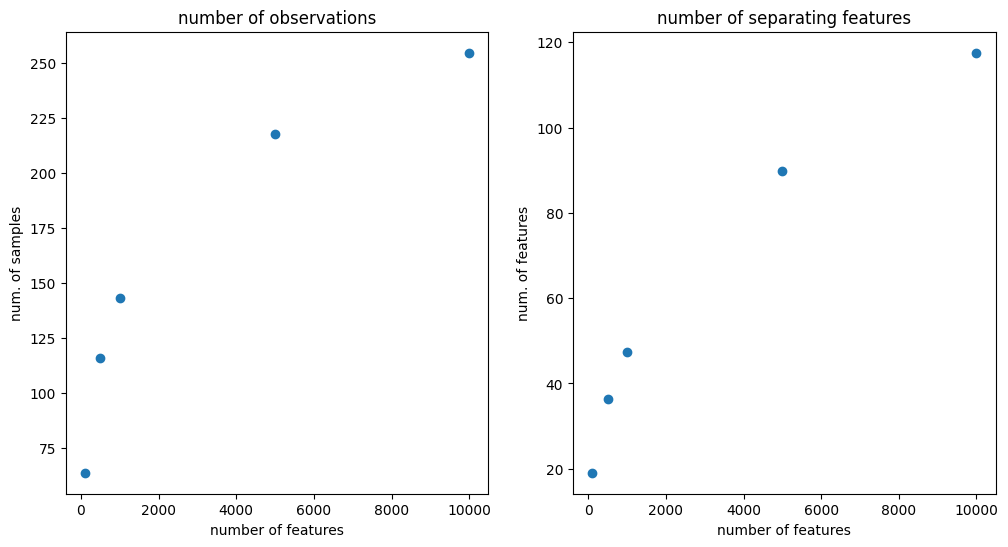

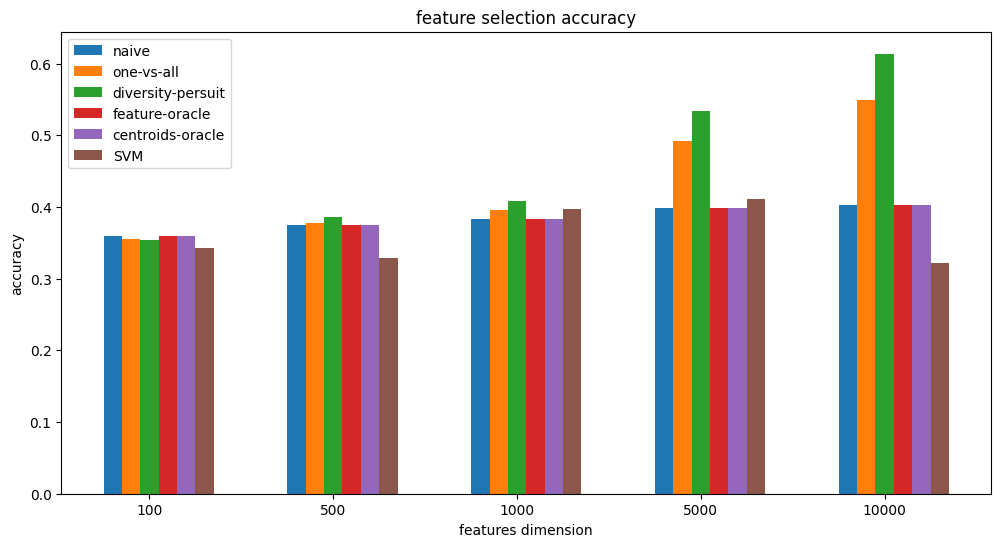

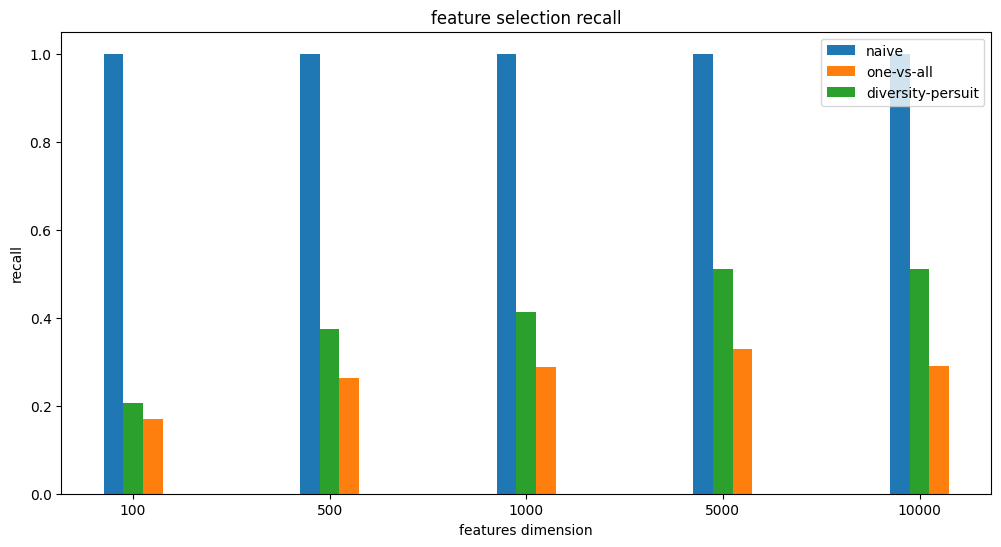

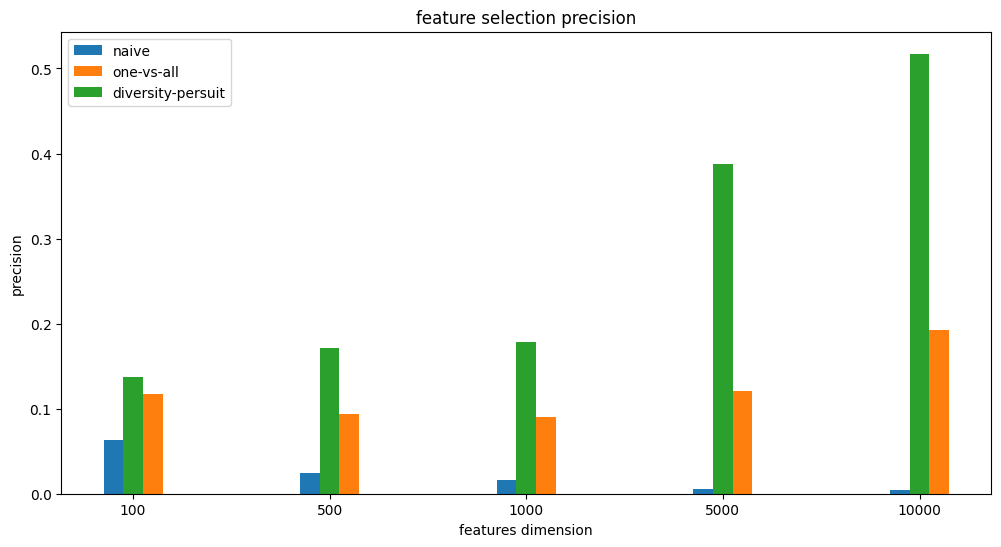

In [4]:
num_experiments = 50
features_num_array = np.array([100,500,1000,5000,10000])
exp_name = 'normal_clusters_classification_feature_dim_scan'
accuracies = np.empty((5,len(features_num_array),num_experiments))
ref_model_accuracies = np.empty((len(features_num_array),))
features_recall = np.empty((3,len(features_num_array),num_experiments))
features_precision = np.empty((3,len(features_num_array),num_experiments))

num_separating_features = np.empty((len(features_num_array),num_experiments))
# signal generation parameters
num_classes = 3
test_frac = .9
sig = 1 # noise intensity
# determine how many features are "meaningful". beta is the rarity - the smaller
# beta is, there are less discriminating features
beta = 0.6
experiment_dict = {"noise_intensity" : sig,
                   "num_classes"     : num_classes,
                   "test_frac"       : test_frac}
print("classification of normally distributed clusters")
print("----------------------------------------------------------------")
for i in range(len(features_num_array)):
    p = features_num_array[i]
    # set the overall number of samples - proportional to log(p)
    n_train = int(3 * np.log(p) ** 2)
    n = int(n_train/(1-test_frac))
    
    eps = p ** (-beta) 
    # square of the signal power scales up logarithmically with the number of features and linearly with the number of classes
    r = 0.01 * num_classes
    mu = np.sqrt(r*np.log(p))
    print(f"classifying data with {p} features, {num_classes} classes, {n_train} train samples")
    print(f"normal distribution mean = {mu}, std = {sig}")
    # use an of-the-shelf classifier on a typical data used in the experiment and compare its accuracy to the basic method tested here
    centroids = synthetic_data_gen.sample_centroids(num_classes=num_classes, num_features=p, eps=eps, power=mu, non_nulls_location='fixed')
    X, y = synthetic_data_gen.sample_normal_clusters(centroids, n, sig)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_frac)
    svm_search_space = {'C' : hp.uniform('C',0.1,10),
                        'kernel': hp.choice('kernel',['linear', 'poly', 'rbf', 'sigmoid']),
                        'degree' : hp.choice('degree',list(range(1,10)))}
    hyper_opt = model_hypopt(model=SVC,param_space=svm_search_space,X_train=X_train, y_train=y_train)
    best_params = hyper_opt.run()
    ref_model = SVC(**best_params)
    ref_model.fit(X_train, y_train)
    ref_model_pred = ref_model.predict(X_test)
    ref_model_acc = accuracy_score(y_test, ref_model_pred)
    print(f"SVM best parameters are {best_params}")
    print(f"SVM accuracy = {ref_model_acc}")
    ref_model_accuracies[i] = ref_model_acc
    for j in range(num_experiments):
        # define centroids locations
        centroids = synthetic_data_gen.sample_centroids(num_classes=num_classes, num_features=p, eps=eps, power=mu, non_nulls_location='fixed')
        # generate normal clusters centered at the centroids
        X, y = synthetic_data_gen.sample_normal_clusters(centroids, n, sig)
        # save the true locations of the discriminating features for error analysis
        true_mask = (centroids != 0)
        num_separating_features[i,j] = np.sum(true_mask)
        # split the data to train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_frac)
        dist_mat = pairwise_distances(centroids)
        distances = dist_mat[np.triu_indices(n=dist_mat.shape[0])]
        delta_mean = np.mean(distances)
        delta_min = np.min(dist_mat + 1e9 * np.eye(len(dist_mat)))
        delta_std = np.std(distances)
        delta_th = mu * np.sqrt(eps * p / 2)
        # init and fit a vanilla classifier - based only on similarity to the centroids
        cs = CentroidSimilarity()
        cs.fit(X_train, y_train)
        accuracies[0,i,j] = cs.eval_accuracy(X_test, y_test)
        recall, precision = cs.get_mask_prec_recall(true_mask)
        features_precision[0,i,j] = precision
        features_recall[0,i,j] = recall
        # define a classifier which selects a subset of the features using one-vs-all ANOVA and higher criticism
        cs_fs_ova = CentroidSimilarityFeatureSelection()
        cs_fs_ova.fit(X_train, y_train, method='one_vs_all')
        pvals_ova = cs_fs_ova.get_pvals(cls_id = 0, method='one_vs_all')
        accuracies[1,i,j] = cs_fs_ova.eval_accuracy(X_test, y_test)
        recall, precision = cs_fs_ova.get_mask_prec_recall(true_mask)
        features_precision[1,i,j] = precision
        features_recall[1,i,j] = recall
        # define a classifier which selects a subset of the features using full one-way ANOVA and higher criticism
        cs_fs_dp = CentroidSimilarityFeatureSelection()
        cs_fs_dp.fit(X_train, y_train, method='diversity_pursuit')
        pvals_dp = cs_fs_dp.get_pvals(cls_id = 0, method='diversity_pursuit')
        accuracies[2,i,j] = cs_fs_dp.eval_accuracy(X_test, y_test)
        recall, precision = cs_fs_dp.get_mask_prec_recall(true_mask)
        features_precision[2,i,j] = precision
        features_recall[2,i,j] = recall
        # test the performance of an "oracle" classifier based on the actual true features
        cs_oracle = CentroidSimilarity()
        cs_oracle.fit(X_train, y_train)
        cs_oracle.mask = true_mask
        accuracies[3,i,j] = cs_oracle.eval_accuracy(X_test, y_test)
        # test the accuracy of a classifier which has the actual centroids 
        cs_oracle_mu = CentroidSimilarity()
        cs_oracle_mu.fit(X_train, y_train)
        cs_oracle_mu.cls_mean = centroids
        cs_oracle_mu.mat = (cs_oracle_mu.cls_mean.T / np.linalg.norm(cs_oracle_mu.cls_mean, axis=1)).T
        accuracies[4,i,j] = cs_oracle_mu.eval_accuracy(X_test, y_test)
    print("-------------------------------------------------------------\n\n")
    

fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(features_num_array,3 * np.log(features_num_array) ** 2,'o')
ax[0].set_xlabel('number of features')
ax[0].set_ylabel('num. of samples')
ax[0].set_title('number of observations')
ax[1].plot(features_num_array,np.mean(num_separating_features,axis=1),'o')
ax[1].set_xlabel('number of features')
ax[1].set_ylabel('num. of features')
ax[1].set_title('number of separating features')
plt.show()

# plot the accuracies
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xticks(np.arange(len(features_num_array)))
ax.bar(x=np.arange(len(features_num_array))-0.2,height=np.mean(accuracies[0],axis=1),width=0.1,label="naive")
ax.bar(x=np.arange(len(features_num_array))-0.1,height=np.mean(accuracies[1],axis=1),width=0.1,label="one-vs-all")
ax.bar(x=np.arange(len(features_num_array))    ,height=np.mean(accuracies[2],axis=1),width=0.1,label="diversity-persuit")
ax.bar(x=np.arange(len(features_num_array))+0.1,height=np.mean(accuracies[3],axis=1),width=0.1,label="feature-oracle")
ax.bar(x=np.arange(len(features_num_array))+0.2,height=np.mean(accuracies[4],axis=1),width=0.1,label="centroids-oracle")
ax.bar(x=np.arange(len(features_num_array))+0.3,height=ref_model_accuracies,width=0.1,label="SVM")
ax.set_xlabel('features dimension')
ax.set_xticklabels(features_num_array)
ax.set_ylabel('accuracy')
ax.set_title('feature selection accuracy')
ax.legend() 
plt.show()



fig, ax = plt.subplots(figsize=(12,6))
ax.set_xticks(np.arange(len(features_num_array)))
ax.bar(x=np.arange(len(features_num_array))-0.1,height=np.mean(features_recall[0],axis=1),width=0.1,label="naive")
ax.bar(x=np.arange(len(features_num_array))+0.1,height=np.mean(features_recall[1],axis=1),width=0.1,label="one-vs-all")
ax.bar(x=np.arange(len(features_num_array))    ,height=np.mean(features_recall[2],axis=1),width=0.1,label="diversity-persuit")
ax.set_xlabel('features dimension')
ax.set_xticklabels(features_num_array)
ax.set_ylabel('recall')
ax.set_title('feature selection recall')
ax.legend() 
plt.show()
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xticks(np.arange(len(features_num_array)))
ax.bar(x=np.arange(len(features_num_array))-0.1,height=np.mean(features_precision[0],axis=1),width=0.1,label="naive")
ax.bar(x=np.arange(len(features_num_array))+0.1,height=np.mean(features_precision[1],axis=1),width=0.1,label="one-vs-all")
ax.bar(x=np.arange(len(features_num_array))    ,height=np.mean(features_precision[2],axis=1),width=0.1,label="diversity-persuit")
ax.set_xlabel('features dimension')
ax.set_xticklabels(features_num_array)
ax.set_ylabel('precision')
ax.set_title('feature selection precision')
ax.legend() 
plt.show()


experiment_dict['accuracies'] = {'naive'           : np.mean(accuracies[0],axis=1), 
                                 'one vs all'      : np.mean(accuracies[1],axis=1), 
                                 'div. persuit'    : np.mean(accuracies[2],axis=1),
                                 'features_oracle' : np.mean(accuracies[3],axis=1),
                                 'location_oracle' : np.mean(accuracies[4],axis=1)}


### Experiment 2: Explore the effect of number of classes
In this experiment the features dimension size is set to $p=5000$, and the number of classes effect on performance is explored.


classification of normally distributed clusters
----------------------------------------------------------------
classifying data with 5000 features, 2 classes, 217 train samples
normal distribution mean = 0.2918423065872431, std = 1
100%|██████████| 150/150 [01:16<00:00,  1.95it/s, best loss: -0.5300211416490487]
SVM best parameters are {'C': 7.450909638251669, 'degree': 5, 'kernel': 'poly'}
SVM accuracy = 0.4976958525345622
------------------------------------------------------------------------------------------


classifying data with 5000 features, 3 classes, 217 train samples
normal distribution mean = 0.3574323682478177, std = 1
100%|██████████| 150/150 [01:26<00:00,  1.74it/s, best loss: -0.43731501057082456]
SVM best parameters are {'C': 1.66528746413028, 'degree': 5, 'kernel': 'sigmoid'}
SVM accuracy = 0.33691756272401435
------------------------------------------------------------------------------------------


classifying data with 5000 features, 5 classes, 217 train sampl

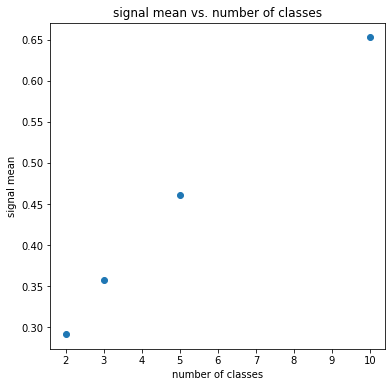

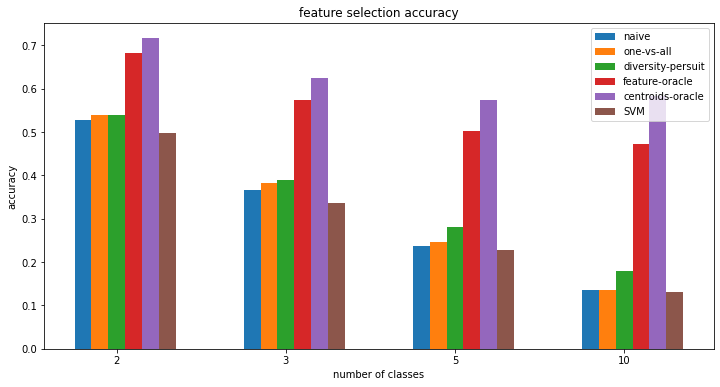

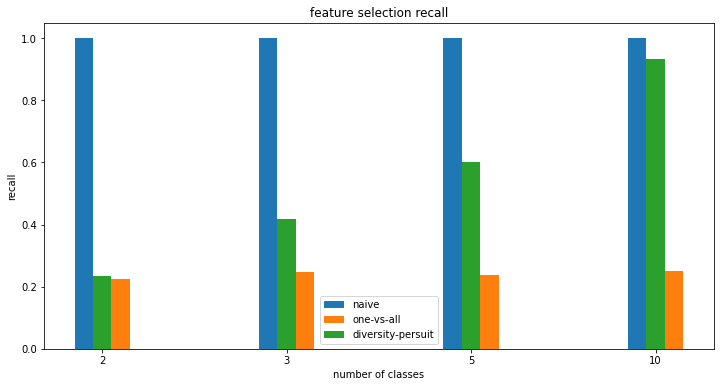

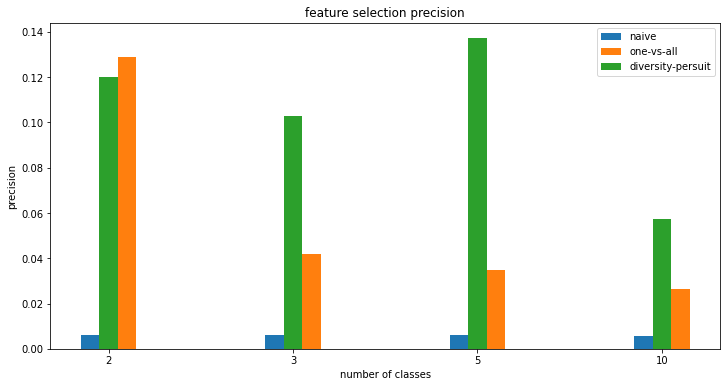

In [ ]:
num_experiments = 100
num_classes_array = np.array([2,3,5,10])
exp_name = 'normal_clusters_classification_number_classes_scan'
accuracies         = np.empty((5,len(num_classes_array),num_experiments))
ref_model_accuracies = np.empty((len(num_classes_array),))
features_recall    = np.empty((3,len(num_classes_array),num_experiments))
features_precision = np.empty((3,len(num_classes_array),num_experiments))
sig_power = []
# signal generation parameters
num_features = 5000
test_frac = 0.9
sig = 1 # noise intensity
# determine how many features are "meaningful". beta is the rarity - the larger
# beta is, there are less discriminating features
beta = 0.6
experiment_dict = {"noise_intensity" : sig,
                   "num_classes"     : num_classes_array,
                   "test_frac"       : test_frac}
print("classification of normally distributed clusters")
print("----------------------------------------------------------------")
for i in range(len(num_classes_array)):
    p = num_features
    # set the number of train samples - proportional to log(p)
    n_train = int(3 * np.log(p) ** 2)
    n = int(n_train/(1-test_frac))
    eps = p ** (-beta) 
    num_classes = num_classes_array[i]
    # square of the signal power scales up logarithmically with the number of features and linearly with the number of classes
    r = 0.005 * num_classes
    mu = np.sqrt(r*np.log(p))
    sig_power.append(mu)
    print(f"classifying data with {p} features, {num_classes} classes, {n_train} train samples")
    print(f"normal distribution mean = {mu}, std = {sig}")
    # use an of-the-shelf classifier on a typical data used in the experiment and compare its accuracy to the basic method tested here
    centroids = synthetic_data_gen.sample_centroids(num_classes=num_classes, num_features=p, eps=eps, power=mu, non_nulls_location='fixed')
    X, y = synthetic_data_gen.sample_normal_clusters(centroids, n, sig)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_frac)
    svm_search_space = {'C' : hp.uniform('C',0.1,10),
                        'kernel': hp.choice('kernel',['linear', 'poly', 'rbf', 'sigmoid']),
                        'degree' : hp.choice('degree',list(range(1,10)))}
    hyper_opt = model_hypopt(model=SVC,param_space=svm_search_space,X_train=X_train, y_train=y_train)
    best_params = hyper_opt.run()
    ref_model = SVC(**best_params)
    ref_model.fit(X_train, y_train)
    ref_model_pred = ref_model.predict(X_test)
    ref_model_acc = accuracy_score(y_test, ref_model_pred)
    print(f"SVM best parameters are {best_params}")
    print(f"SVM accuracy = {ref_model_acc}")
    ref_model_accuracies[i] = ref_model_acc
    for j in range(num_experiments):
        
        # define centroids locations
        centroids = synthetic_data_gen.sample_centroids(num_classes=num_classes, num_features=p, eps=eps, power=mu, non_nulls_location='fixed')
        # generate normal clusters centered at the centroids
        X, y = synthetic_data_gen.sample_normal_clusters(centroids, n, sig)
        # save the true locations of the discriminating features for error analysis
        true_mask = (centroids != 0)
        # split the data to train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_frac)
        dist_mat = pairwise_distances(centroids)
        distances = dist_mat[np.triu_indices(n=dist_mat.shape[0])]
        delta_mean = np.mean(distances)
        delta_min = np.min(dist_mat + 1e9 * np.eye(len(dist_mat)))
        delta_std = np.std(distances)
        delta_th = mu * np.sqrt(eps * p / 2)
        # init and fit a vanilla classifier - based only on similarity to the centroids
        cs = CentroidSimilarity()
        cs.fit(X_train, y_train)
        accuracies[0,i,j] = cs.eval_accuracy(X_test, y_test)
        recall, precision = cs.get_mask_prec_recall(true_mask)
        features_precision[0,i,j] = precision
        features_recall[0,i,j] = recall
        # define a classifier which selects a subset of the features using one-vs-all ANOVA and higher criticism
        cs_fs_ova = CentroidSimilarityFeatureSelection()
        cs_fs_ova.fit(X_train, y_train, method='one_vs_all')
        pvals_ova = cs_fs_ova.get_pvals(cls_id = 0, method='one_vs_all')
        accuracies[1,i,j] = cs_fs_ova.eval_accuracy(X_test, y_test)
        recall, precision = cs_fs_ova.get_mask_prec_recall(true_mask)
        features_precision[1,i,j] = precision
        features_recall[1,i,j] = recall
        # define a classifier which selects a subset of the features using full one-way ANOVA and higher criticism
        cs_fs_dp = CentroidSimilarityFeatureSelection()
        cs_fs_dp.fit(X_train, y_train, method='diversity_pursuit')
        pvals_dp = cs_fs_dp.get_pvals(cls_id = 0, method='diversity_pursuit')
        accuracies[2,i,j] = cs_fs_dp.eval_accuracy(X_test, y_test)
        recall, precision = cs_fs_dp.get_mask_prec_recall(true_mask)
        features_precision[2,i,j] = precision
        features_recall[2,i,j] = recall
        # test the performance of an "oracle" classifier based on the actual true features
        cs_oracle = CentroidSimilarity()
        cs_oracle.fit(X_train, y_train)
        cs_oracle.mask = true_mask
        accuracies[3,i,j] = cs_oracle.eval_accuracy(X_test, y_test)
        # test the accuracy of a classifier which has the actual centroids 
        cs_oracle_mu = CentroidSimilarity()
        cs_oracle_mu.fit(X_train, y_train)
        cs_oracle_mu.cls_mean = centroids
        cs_oracle_mu.mat = (cs_oracle_mu.cls_mean.T / np.linalg.norm(cs_oracle_mu.cls_mean, axis=1)).T
        accuracies[4,i,j] = cs_oracle_mu.eval_accuracy(X_test, y_test)
    print("------------------------------------------------------------------------------------------\n\n")

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(num_classes_array,sig_power,'o')
ax.set_xlabel('number of classes')
ax.set_ylabel('signal mean')
ax.set_title('signal mean vs. number of classes')

plt.show()

# plot the accuracies
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xticks(np.arange(len(num_classes_array)))
ax.bar(x=np.arange(len(num_classes_array))-0.2,height=np.mean(accuracies[0],axis=1),width=0.1,label="naive")
ax.bar(x=np.arange(len(num_classes_array))-0.1,height=np.mean(accuracies[1],axis=1),width=0.1,label="one-vs-all")
ax.bar(x=np.arange(len(num_classes_array))    ,height=np.mean(accuracies[2],axis=1),width=0.1,label="diversity-persuit")
ax.bar(x=np.arange(len(num_classes_array))+0.1,height=np.mean(accuracies[3],axis=1),width=0.1,label="feature-oracle")
ax.bar(x=np.arange(len(num_classes_array))+0.2,height=np.mean(accuracies[4],axis=1),width=0.1,label="centroids-oracle")
ax.bar(x=np.arange(len(num_classes_array))+0.3,height=ref_model_accuracies,width=0.1,label="SVM")
ax.set_xlabel('number of classes')
ax.set_xticklabels(num_classes_array)
ax.set_ylabel('accuracy')
ax.set_title('feature selection accuracy')
ax.legend() 
plt.show()



fig, ax = plt.subplots(figsize=(12,6))
ax.set_xticks(np.arange(len(num_classes_array)))
ax.bar(x=np.arange(len(num_classes_array))-0.1,height=np.mean(features_recall[0],axis=1),width=0.1,label="naive")
ax.bar(x=np.arange(len(num_classes_array))+0.1,height=np.mean(features_recall[1],axis=1),width=0.1,label="one-vs-all")
ax.bar(x=np.arange(len(num_classes_array))    ,height=np.mean(features_recall[2],axis=1),width=0.1,label="diversity-persuit")
ax.set_xlabel('number of classes')
ax.set_xticklabels(num_classes_array)
ax.set_ylabel('recall')
ax.set_title('feature selection recall')
ax.legend() 
plt.show()
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xticks(np.arange(len(num_classes_array)))
ax.bar(x=np.arange(len(num_classes_array))-0.1,height=np.mean(features_precision[0],axis=1),width=0.1,label="naive")
ax.bar(x=np.arange(len(num_classes_array))+0.1,height=np.mean(features_precision[1],axis=1),width=0.1,label="one-vs-all")
ax.bar(x=np.arange(len(num_classes_array))    ,height=np.mean(features_precision[2],axis=1),width=0.1,label="diversity-persuit")
ax.set_xlabel('number of classes')
ax.set_xticklabels(num_classes_array)
ax.set_ylabel('precision')
ax.set_title('feature selection precision')
ax.legend() 
plt.show()


experiment_dict['accuracies'] = {'naive'           : np.mean(accuracies[0],axis=1), 
                                 'one vs all'      : np.mean(accuracies[1],axis=1), 
                                 'div. persuit'    : np.mean(accuracies[2],axis=1),
                                 'features_oracle' : np.mean(accuracies[3],axis=1),
                                 'location_oracle' : np.mean(accuracies[4],axis=1)}


### Experiment 3: Explore the effect of number of classes, with fixed signal "power"
This experiment's goal is to check whether the increase in precision observed in experiment 2 when the number of classes grow is because the centroids mean (of non-null features) grows with the number of classes. this experiment will keep the mean constant


classification of normally distributed clusters
----------------------------------------------------------------


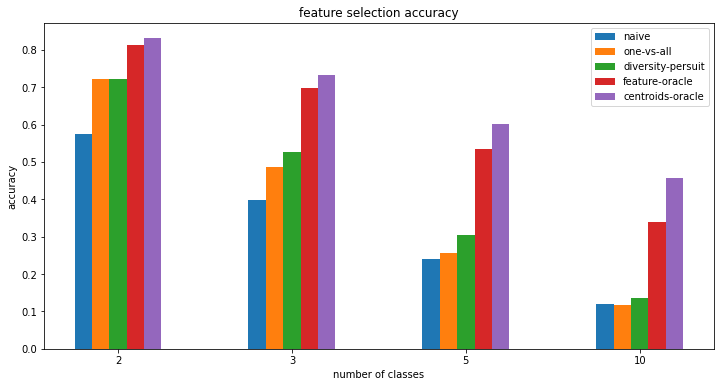

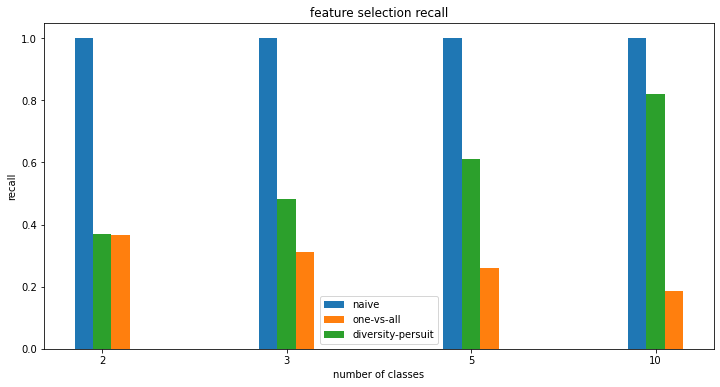

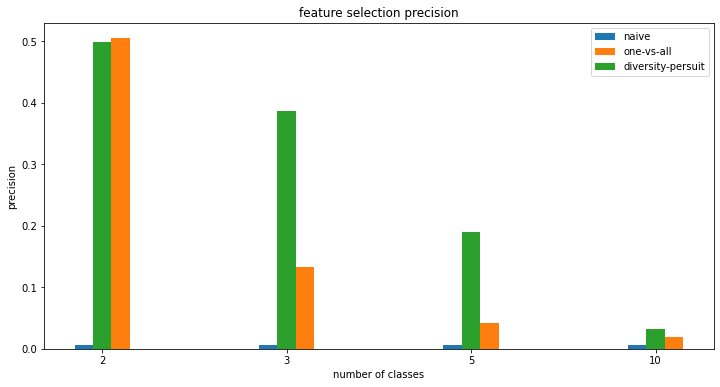

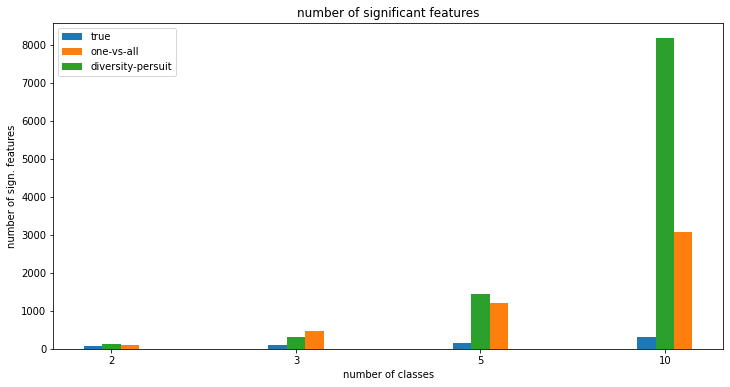

In [ ]:
num_experiments = 100
num_classes_array = np.array([2,3,5,10])
exp_name = 'normal_clusters_classification_number_classes_scan'
accuracies         = np.empty((5,len(num_classes_array),num_experiments))
features_recall    = np.empty((3,len(num_classes_array),num_experiments))
features_precision = np.empty((3,len(num_classes_array),num_experiments))
number_features_found = np.empty((3,len(num_classes_array),num_experiments))
# signal generation parameters
num_features = 5000
test_frac = 0.9
sig = 1 # noise intensity
# determine how many features are "meaningful". beta is the rarity - the smaller
# beta is, there are less discriminating features
beta = 0.6
mu = 0.5
experiment_dict = {"noise_intensity" : sig,
                   "num_classes"     : num_classes_array,
                   "test_frac"       : test_frac}
print("classification of normally distributed clusters")
print("----------------------------------------------------------------")
for i in range(len(num_classes_array)):
    p = num_features
    # set the number of train samples - proportional to log(p)
    n_train = int(3 * np.log(p) ** 2)
    n = int(n_train/(1-test_frac))
    eps = p ** (-beta) 
    num_classes = num_classes_array[i]
    
    for j in range(num_experiments):
        
        # define centroids locations
        centroids = synthetic_data_gen.sample_centroids(num_classes=num_classes, num_features=p, eps=eps, power=mu, non_nulls_location='fixed')
        # generate normal clusters centered at the centroids
        X, y = synthetic_data_gen.sample_normal_clusters(centroids, n, sig)
        # save the true locations of the discriminating features for error analysis
        true_mask = (centroids != 0)
        # store the number of non-null features
        number_features_found[0,i,j] = np.sum(true_mask)
        # split the data to train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_frac)
        # init and fit a vanilla classifier - based only on similarity to the centroids
        cs = CentroidSimilarity()
        cs.fit(X_train, y_train)
        accuracies[0,i,j] = cs.eval_accuracy(X_test, y_test)
        recall, precision = cs.get_mask_prec_recall(true_mask)
        features_precision[0,i,j] = precision
        features_recall[0,i,j] = recall
        # define a classifier which selects a subset of the features using one-vs-all ANOVA and higher criticism
        cs_fs_ova = CentroidSimilarityFeatureSelection()
        cs_fs_ova.fit(X_train, y_train, method='one_vs_all')
        pvals_ova = cs_fs_ova.get_pvals(cls_id = 0, method='one_vs_all')
        accuracies[1,i,j] = cs_fs_ova.eval_accuracy(X_test, y_test)
        recall, precision = cs_fs_ova.get_mask_prec_recall(true_mask)
        features_precision[1,i,j] = precision
        features_recall[1,i,j] = recall
        number_features_found[1,i,j] = np.sum(cs_fs_ova.mask)
        # define a classifier which selects a subset of the features using full one-way ANOVA and higher criticism
        cs_fs_dp = CentroidSimilarityFeatureSelection()
        cs_fs_dp.fit(X_train, y_train, method='diversity_pursuit')
        pvals_dp = cs_fs_dp.get_pvals(cls_id = 0, method='diversity_pursuit')
        accuracies[2,i,j] = cs_fs_dp.eval_accuracy(X_test, y_test)
        recall, precision = cs_fs_dp.get_mask_prec_recall(true_mask)
        features_precision[2,i,j] = precision
        features_recall[2,i,j] = recall
        number_features_found[2,i,j] = np.sum(cs_fs_dp.mask)
        # test the performance of an "oracle" classifier based on the actual true features
        cs_oracle = CentroidSimilarity()
        cs_oracle.fit(X_train, y_train)
        cs_oracle.mask = true_mask
        accuracies[3,i,j] = cs_oracle.eval_accuracy(X_test, y_test)
        # test the accuracy of a classifier which has the actual centroids 
        cs_oracle_mu = CentroidSimilarity()
        cs_oracle_mu.fit(X_train, y_train)
        cs_oracle_mu.cls_mean = centroids
        cs_oracle_mu.mat = (cs_oracle_mu.cls_mean.T / np.linalg.norm(cs_oracle_mu.cls_mean, axis=1)).T
        accuracies[4,i,j] = cs_oracle_mu.eval_accuracy(X_test, y_test)

# plot the accuracies
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xticks(np.arange(len(num_classes_array)))
ax.bar(x=np.arange(len(num_classes_array))-0.2,height=np.mean(accuracies[0],axis=1),width=0.1,label="naive")
ax.bar(x=np.arange(len(num_classes_array))-0.1,height=np.mean(accuracies[1],axis=1),width=0.1,label="one-vs-all")
ax.bar(x=np.arange(len(num_classes_array))    ,height=np.mean(accuracies[2],axis=1),width=0.1,label="diversity-persuit")
ax.bar(x=np.arange(len(num_classes_array))+0.1,height=np.mean(accuracies[3],axis=1),width=0.1,label="feature-oracle")
ax.bar(x=np.arange(len(num_classes_array))+0.2,height=np.mean(accuracies[4],axis=1),width=0.1,label="centroids-oracle")
ax.set_xlabel('number of classes')
ax.set_xticklabels(num_classes_array)
ax.set_ylabel('accuracy')
ax.set_title('feature selection accuracy')
ax.legend() 
plt.show()

# plot the feature recall
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xticks(np.arange(len(num_classes_array)))
ax.bar(x=np.arange(len(num_classes_array))-0.1,height=np.mean(features_recall[0],axis=1),width=0.1,label="naive")
ax.bar(x=np.arange(len(num_classes_array))+0.1,height=np.mean(features_recall[1],axis=1),width=0.1,label="one-vs-all")
ax.bar(x=np.arange(len(num_classes_array))    ,height=np.mean(features_recall[2],axis=1),width=0.1,label="diversity-persuit")
ax.set_xlabel('number of classes')
ax.set_xticklabels(num_classes_array)
ax.set_ylabel('recall')
ax.set_title('feature selection recall')
ax.legend() 
plt.show()

# plot the feature precision
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xticks(np.arange(len(num_classes_array)))
ax.bar(x=np.arange(len(num_classes_array))-0.1,height=np.mean(features_precision[0],axis=1),width=0.1,label="naive")
ax.bar(x=np.arange(len(num_classes_array))+0.1,height=np.mean(features_precision[1],axis=1),width=0.1,label="one-vs-all")
ax.bar(x=np.arange(len(num_classes_array))    ,height=np.mean(features_precision[2],axis=1),width=0.1,label="diversity-persuit")
ax.set_xlabel('number of classes')
ax.set_xticklabels(num_classes_array)
ax.set_ylabel('precision')
ax.set_title('feature selection precision')
ax.legend() 
plt.show()

# plot the feature precision
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xticks(np.arange(len(num_classes_array)))
ax.bar(x=np.arange(len(num_classes_array))-0.1,height=np.mean(number_features_found[0],axis=1),width=0.1,label="true")
ax.bar(x=np.arange(len(num_classes_array))+0.1,height=np.mean(number_features_found[1],axis=1),width=0.1,label="one-vs-all")
ax.bar(x=np.arange(len(num_classes_array))    ,height=np.mean(number_features_found[2],axis=1),width=0.1,label="diversity-persuit")
ax.set_xlabel('number of classes')
ax.set_xticklabels(num_classes_array)
ax.set_ylabel('number of sign. features')
ax.set_title('number of significant features')
ax.legend() 
plt.show()


experiment_dict['accuracies'] = {'naive'           : np.mean(accuracies[0],axis=1), 
                                 'one vs all'      : np.mean(accuracies[1],axis=1), 
                                 'div. persuit'    : np.mean(accuracies[2],axis=1),
                                 'features_oracle' : np.mean(accuracies[3],axis=1),
                                 'location_oracle' : np.mean(accuracies[4],axis=1)}
